# Landmark Features

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import cv2
import dlib
import tensorflow 
from keras.preprocessing import image

/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorf

## Let's create a path to all the images using the os library

In [2]:
global basedir, image_paths, target_size
basedir = './datasets/celeba'
images_dir = os.path.join(basedir,'img')
labels_filename = 'labels2.csv'

For this task we will use the Facial Landmark approchach. "The aim is to find frontal human faces in an image and estimate their pose. The pose takes the form of 68 landmarks. These are points on the face such as the corners of the mouth, along the eyebrows, on the eyes, and so forth." (http://dlib.net/face_landmark_detection.py.html)

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

## Now we will define three functions from label2_landmark.py as follow

In [4]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

In [5]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [6]:
def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64) ## 5000 lines

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image

In [7]:
def extract_features_labels():
    
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)] # Créer un path en incluant le nom de chaque mage ?
    target_size = None
    labels_file = open(os.path.join(basedir, labels_filename), 'r')
    lines = labels_file.readlines()
    gender_labels = {line.split(',')[0] : int(line.split(',')[2]) for line in lines[1:]}
    if os.path.isdir(images_dir): # SI le Path existe 
        all_features = []
        all_labels = []
        for img_path in image_paths: # Pour chaque image 
            file_name= img_path.split('.')[1].split('/')[-1]

            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_labels.append(gender_labels[file_name])

    landmark_features = np.array(all_features)
    gender_labels = (np.array(all_labels) + 1)/2 # simply converts the -1 into 0, so male=0 and female=1
    return landmark_features, gender_labels

## First we want to visualise the 68 labels on a scattered plot to ensure these functions are fully working

In [8]:
feature_1, feature_2 = extract_features_labels()

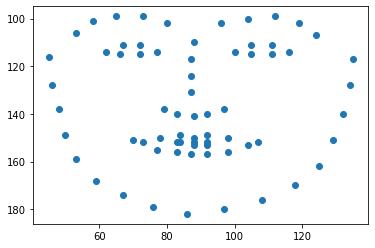

In [9]:
Feature = feature_1[0]
a,b = Feature.T
plt.scatter(a,b)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

# Linear SVC:

We will exctract the features from the pictures and the gender value from the csv file (with 0 instead of -1 for the male), using the extract_features_labels() function and separate these features into a training and testing set.

In [10]:
def get_data():

    X, y = extract_features_labels()
    Y = np.array([y, -(y - 1)]).T
    tr_X = X[:3500]
    tr_Y = Y[:3500]
    te_X = X[3500:]
    te_Y = Y[3500:]

    return tr_X, tr_Y, te_X, te_Y

In [11]:
tr_X, tr_Y, te_X, te_Y= get_data()

In [12]:
tr_X.shape

(3500, 68, 2)

In [15]:
te_X.shape

(1300, 68, 2)

## Import sklearn functions for the classification

In [13]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn import svm

In [16]:
def img_SVM(training_images, training_labels, test_images, test_labels):
    classifier = svm.SVC(kernel = 'linear')
    classifier.fit(training_images, training_labels)
    pred = classifier.predict(test_images)
    print("Accuracy:", accuracy_score(test_labels, pred))

    print(pred)
    return pred

pred=img_SVM(tr_X.reshape((3500, 68*2)), list(zip(*tr_Y))[0], te_X.reshape((1300, 68*2)), list(zip(*te_Y))[0])


Accuracy: 0.9292307692307692
[1. 1. 0. ... 0. 1. 0.]


Therefore, using this model we get an accuracy of approximately 93%

# K-Neighbors Classifier

## Import Libraries

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [18]:
X, y = extract_features_labels()

In [19]:
X.shape, y.shape
X = X.reshape(4800,68*2)
X.shape

(4800, 136)

Split dataset

In [20]:
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=3)

In [21]:
print('train set: {}  | test set: {}'.format(round(((len(y_train)*1.0)/len(X)),3), round((len(y_test)*1.0)/len(X),3)))

train set: 0.7  | test set: 0.3


In [22]:
X_train.shape, y_train.shape, y_train

((3360, 136), (3360,), array([1., 0., 0., ..., 1., 0., 0.]))

Create a function to run a K-Neighbours Classifier using scikit learn library

In [23]:
def KNNClassifier(X_train, y_train, X_test,k):

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train) # Fit KNN model


    Y_pred = neigh.predict(X_test)
    return Y_pred




Y_pred =KNNClassifier(X_train, y_train, X_test,4)
  

score=metrics.accuracy_score(y_test,Y_pred)
print(score)

0.7736111111111111
